In [1]:
import numpy as np
import itertools

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

def append_path(path):
    if path not in sys.path:
        sys.path.append(path)

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)
        
append_path(os.path.abspath(os.path.join('..', '00_utils')))
append_path(os.path.abspath(os.path.join('..', '00_utils_training')))
append_path(os.path.abspath(os.path.join('..', '00_models')))

import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

1. Train the model with Pyomo
    * the main hyperparameter if the number of epochs
2. Initialize JAX model with the trained Pyomo weights and biases

In [9]:
def run(optimization_type, max_iter):
  Trainer = reload_module('run_train_toy', 'TrainerToy')
  
  tol = 1e-4
  params_model = {
      'layer_widths': [2, 32, 2],
      'act_func': 'tanh',
      'penalty_lambda_reg': 0.001,
      'time_invariant': True,
      'w_init_method': 'xavier',
      "reg_norm": False,
      "skip_collocation": np.inf,
      'params': 
              {
            "tol":tol, 
            "acceptable_iter": 0,    
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": max_iter}
              }

  trainer = Trainer.load_trainer("vdp")
  results = {}

  if optimization_type == 'regularization':
    param_combinations = [0, 1e-6, 0.0001, 0.01, 0.1, 1]

  elif optimization_type == 'max_iter':
      max_iter_li = np.array([i for i in range(1, 100)])
      param_combinations = max_iter_li * 1
      converged = False
        
  elif optimization_type == 'none':
    param_combinations = [0]  
  
  else:
    raise ValueError(f"Invalid optimization type {optimization_type}")
      
  total_iter = len(param_combinations)
  i = 1

  for param_comb in param_combinations:
      # PARAMETER UPDATE
      if optimization_type == 'regularization':
          params_model['penalty_lambda_reg'] = param_comb

      elif optimization_type == 'max_iter':
          params_model['params']['max_iter'] = param_comb
          if converged:
            continue
      
      elif optimization_type == 'none':
          pass
     
      try:
        trainer.train_pyomo(params_model)
        if optimization_type == 'max_iter' and 'optimal' in trainer.termination:
          print(f"Optimal solution found at/before iteration {param_comb}")
          converged = True
          
      except Exception as e:
        results[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        logging.error("Failed to complete training: {}".format(e))
        print(f"{e}")
        continue
      
      try:
        if optimization_type == 'network_size_grid_search':
          k = (param_comb[0][1], param_comb[1], param_comb[2])
          results[k] = trainer.extract_results_pyomo()
        else:
          results[param_comb] = trainer.extract_results_pyomo()
      except Exception as e:
        results[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        results.error("Failed to extract results: {}".format(e))
        print(f"{e}")
      
      print("Iteration:", i, "/", total_iter)
      i+=1
      
  return trainer, results

In [10]:
trainer, results = run('none', max_iter=100)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   131342
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    64729

Total number of variables............................:      562
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      562
                     variables with only upper bounds:       

In [11]:
results

{0: {'time_elapsed': 7.964180946350098,
  'mse_train': Array(0.02190402, dtype=float64),
  'mse_test': Array(0.61204147, dtype=float64),
  'termination': <TerminationCondition.optimal: 'optimal'>}}

In [12]:
# pickle trained weights and biases
reload = True
if reload:
    wb_trained = trainer.extract_pyomo_weights()

    custom_params = {
        'Dense_0': {
            'kernel': jnp.array(wb_trained['W1']).T,
            'bias': jnp.array(wb_trained['b1'])
        },
        'Dense_1': {
            'kernel': jnp.array(wb_trained['W2']).T,
            'bias': jnp.array(wb_trained['b2'])
        }
    }

    custom_params['time_elapsed'] = results[0]['time_elapsed']
    custom_params['layer_width'] = trainer.layer_widths
    with open("../00_trained_wb/trained_wb_32.pkl", "wb") as f:
        pickle.dump(custom_params, f)
else:
    with open("../00_trained_wb/trained_wb_32.pkl", "rb") as f:
        custom_params = pickle.load(f)

In [13]:
custom_params

{'Dense_0': {'kernel': Array([[ 0.36610046, -0.0298758 , -0.65141706, -0.36610046,  0.88079551,
           0.36610046, -0.0298758 , -0.0298758 , -0.36243549,  0.36610046,
           0.36610046,  0.36243549,  1.27403134,  0.36610046, -0.06986662,
           0.36610046, -0.36243549, -0.88079551,  0.19570378,  0.0298758 ,
          -0.88079551, -0.36610046, -0.0298758 ,  0.88079551,  0.36243549,
           0.88079551,  0.36610423, -0.56454757,  0.0298758 ,  0.0298758 ,
          -1.27403134,  0.0298758 ],
         [-0.15369994,  0.2787107 , -1.41783254,  0.15369994,  0.43448493,
          -0.15369994,  0.2787107 ,  0.2787107 , -0.03383543, -0.15369994,
          -0.15369994,  0.03383543, -0.45060809, -0.15369994,  1.37819393,
          -0.15369994, -0.03383543, -0.43448493, -1.27610432, -0.2787107 ,
          -0.43448493,  0.15369994,  0.2787107 ,  0.43448493,  0.03383543,
           0.43448493, -0.15377886, -0.5096143 , -0.2787107 , -0.2787107 ,
           0.45060809, -0.2787107 ]], dtyp

In [24]:
def run_diffrax(optimization_type, layer_width, learning_rate = 1e-3, reg_lambda = 1e-5, custom_params=None, pretrain = False, max_iter = 1000):
  Trainer = reload_module('run_train_toy', 'TrainerToy')
  TRAINER = Trainer.load_trainer("vdp", 'uniform', 'jax_diffrax')
  RESULTS = {}

  params_model = {
      'layer_widths': layer_width,
      'penalty_lambda_reg': reg_lambda,
      'time_invariant': True,
      'learning_rate': learning_rate,
      'pretrain': [0.2, 1],
      'verbose': False,
      'rtol': 1e-3,
      'atol': 1e-6,
      "log": False,
      'act_func': 'tanh',
      'split_time': True
  }

  if pretrain:
    params_model['pretrain'] = [0.2, 1]
    params_model['max_iter'] = max_iter
  else:
    params_model['pretrain'] = False
    params_model['max_iter'] = max_iter

  if optimization_type == 'none':
    param_combinations = [0]
  elif optimization_type == 'training_convergence':
    param_combinations = [0] 
    params_model['log'] = 100  
  else:
    raise ValueError("Invalid optimization type")

  total_iter = len(param_combinations)
  i = 1

  for param_comb in param_combinations:
      if optimization_type == 'training_convergence':
        pass
      elif optimization_type == 'none':
        pass
      else:
        raise ValueError("Invalid optimization type")
      
      print(params_model['log'])
      try:
        TRAINER.train(params_model, custom_params)
      except Exception as e:
        print("Failed to complete training: {}".format(e))
        logging.error("Failed to complete training: {}".format(e))
        continue
      
      result = TRAINER.extract_results()
      print(param_comb)
        
      RESULTS[param_comb] = result
      
      if optimization_type == 'training_convergence':
          training_loss = TRAINER.losses
          RESULTS[param_comb]['training_loss'] = training_loss
      
      print(RESULTS[param_comb]['mse_train'])
      print(RESULTS[param_comb]['mse_test'])
      print("Iteration:", i, "/", total_iter)
      i+=1
      
  return RESULTS, TRAINER

In [31]:
wb_trained = trainer.extract_pyomo_weights()

custom_params = {
    'Dense_0': {
        'kernel': jnp.array(wb_trained['W1']).T,
        'bias': jnp.array(wb_trained['b1'])
    },
    'Dense_1': {
        'kernel': jnp.array(wb_trained['W2']).T,
        'bias': jnp.array(wb_trained['b2'])
    }
}

Trainer = reload_module('run_train_toy', 'TrainerToy')

#results_jax, trainer_jax = run_diffrax('none', trainer.layer_widths, custom_params = custom_params, learning_rate=1e-7, reg_lambda=1e-5, max_iter=30000)
results_jax_ind, trainer_jax_ind = run_diffrax('none', [2, 64, 2], pretrain = True, learning_rate=1e-3, reg_lambda=1e-5, max_iter= [1000, 30000])

False
0
0.03686220463847314
0.9505603483636722
Iteration: 1 / 1


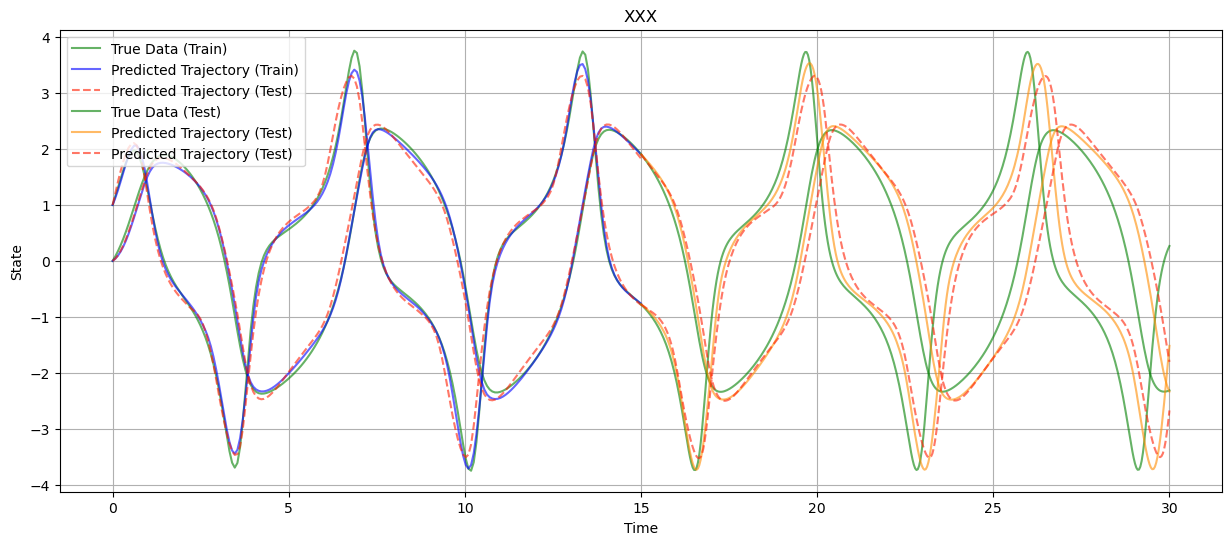

In [40]:
result = trainer_jax.extract_results_diffrax(True)
result_ind = trainer_jax_ind.extract_results_diffrax(True)
y_pred, y_pred_test = result['odeint_pred'], result['odeint_pred_test']
y_pred_ind, y_pred_test_ind = result_ind['odeint_pred'], result_ind['odeint_pred_test']

plt.figure(figsize=(15, 6))

plt.plot(trainer_jax.t, trainer_jax.y[:,0], color = 'green', label='True Data (Train)', alpha = 0.6)
plt.plot(trainer_jax.t, trainer_jax.y[:,1], color = 'green', alpha = 0.6)
plt.plot(trainer_jax.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
plt.plot(trainer_jax.t, y_pred[:,1], color = 'blue', alpha = 0.6)
plt.plot(trainer_jax_ind.t, y_pred_ind[:,0], color='#FF1C00', ls = '--', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.plot(trainer_jax_ind.t, y_pred_ind[:,1], color='#FF1C00', ls = '--', alpha = 0.6)

plt.plot(trainer_jax.t_test, trainer_jax.y_test[:,0], color='green', label='True Data (Test)', alpha = 0.6)
plt.plot(trainer_jax.t_test, trainer_jax.y_test[:,1], color='green', alpha = 0.6)
plt.plot(trainer_jax.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.plot(trainer_jax.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)
plt.plot(trainer_jax_ind.t_test, y_pred_test_ind[:,0], color='#FF1C00', ls = '--', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.plot(trainer_jax_ind.t_test, y_pred_test_ind[:,1], color='#FF1C00', ls = '--', alpha = 0.6)

plt.title(f"XXX")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

In [15]:
results= run_diffrax('training_convergence', trainer.layer_widths, custom_params = custom_params, max_iter=20000, learning_rate=1e-7, reg_lambda=1e-5)
# results = run_diffrax('training_convergence', [2, 64, 2], pretrain = True, learning_rate=1e-3, reg_lambda=1e-5, max_iter=[1000, 30000])
results

100
0
0.010548810558212674
0.5825033589076349
Iteration: 1 / 1


{0: {'time_elapsed': 146.23430609703064,
  'mse_train': Array(0.01054881, dtype=float64),
  'mse_test': Array(0.58250336, dtype=float64),
  'training_loss': [([0.03502465860488416,
     0.10385652244967507,
     0.021274407619125107,
     0.01942563287618129,
     0.024617336494174483,
     0.01872919790722107,
     0.018330438334203402,
     0.017910300140370032,
     0.018376988770011815,
     0.01708774755606192,
     0.016817375288218674,
     0.022356303905927973,
     0.026298515357110697,
     0.02621158019647608,
     0.014959246538552263,
     0.014919720575976307,
     0.014510741878016278,
     0.014549018453732345,
     0.017650009037172378,
     0.025515653172316556,
     0.02536230213613933,
     0.013666591981187264,
     0.013511936030779896,
     0.013103047852657312,
     0.013677284180448734,
     0.01329719711060335,
     0.012812523053006444,
     0.012717132148020146,
     0.012956136283082781,
     0.012707149338766594,
     0.014831040544317694,
     0.012773443

In [16]:
suffix = '_32_pyomo'

reload = True
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/diffrax_pyomo_pretraining{suffix}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
        
    print(f"Results saved to {filename}")

if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/diffrax_pyomo_pretraining_time{suffix}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(results_jax, file)
        
    print(f"Results saved to {filename}")

Results saved to results/diffrax_pyomo_pretraining_32_pyomo.pkl
Results saved to results/diffrax_pyomo_pretraining_time_32_pyomo.pkl
